<a href="https://colab.research.google.com/github/sheltauro/makemore/blob/main/wavenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
read_data = requests.get('https://raw.githubusercontent.com/sheltauro/makemore/main/data/names.txt').content
read_data = read_data.splitlines()
words = [str(rd, 'UTF-8') for rd in read_data]

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size=27
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [74]:
# building the dataset

block_size = 8 # context length: how many characters fo we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', ch)
      context = context[1:] + [ix] # crop and append
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [128]:
# Let's train a deeper neural network

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / (fan_in**0.5) # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim) # gain
    self.beta = torch.zeros(dim) # bias
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # forward pass
    if (self.training):
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)
      x_mean = x.mean(dim, keepdim=True)
      x_var = x.var(dim, keepdim=True)
    else:
      x_mean = self.running_mean
      x_var = self.running_var

    xhat = ((x - x_mean) / torch.sqrt(x_var + self.eps)) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta

    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn(num_embeddings, embedding_dim)

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]


class FlattenConsecutive:
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if (x.shape[1] == 1):
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []


class Sequential:
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return x

  def parameters(self):
    # get parameters of all layers and stretch them out into one list.
    return [p for layer in self.layers for p in layer.parameters()]

In [129]:
torch.manual_seed(42) # seed rng for reproducibility

In [130]:
n_embd = 10 # dimensionality of the character embedding vectors.
n_hidden = 68 # number of neurons in the hidden layer of the MLP

# C = torch.randn((vocab_size, n_embd))
model = Sequential([
    Embedding(vocab_size, n_embd), 
    FlattenConsecutive(2),
    Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
  # last layer: make less confident
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of total parameters
for p in parameters:
  p.requires_grad = True

22397


In [120]:
# logits = model(Xb)
# for layer in model.layers:
#   print(layer.__class__.__name__, ':', tuple(layer.out.shape))

AttributeError: ignored

In [131]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,)) # picking 32 random elements
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss_function

  # backward pass
  for p in parameters:
    # print(p.shape)
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item()) # Storing the log loss

  if i >= 200000:
    break # AFTER_DEBUG: would take out to run full optimisation

      0/ 200000: 3.3136
  10000/ 200000: 2.1918
  20000/ 200000: 2.2621
  30000/ 200000: 1.7221
  40000/ 200000: 1.9945
  50000/ 200000: 2.0432
  60000/ 200000: 1.7693
  70000/ 200000: 2.2785
  80000/ 200000: 2.4334
  90000/ 200000: 2.3987
 100000/ 200000: 2.0473
 110000/ 200000: 2.2596
 120000/ 200000: 1.9175
 130000/ 200000: 1.8445
 140000/ 200000: 1.9885
 150000/ 200000: 1.9614
 160000/ 200000: 1.7268
 170000/ 200000: 2.4423
 180000/ 200000: 1.7845
 190000/ 200000: 2.1223


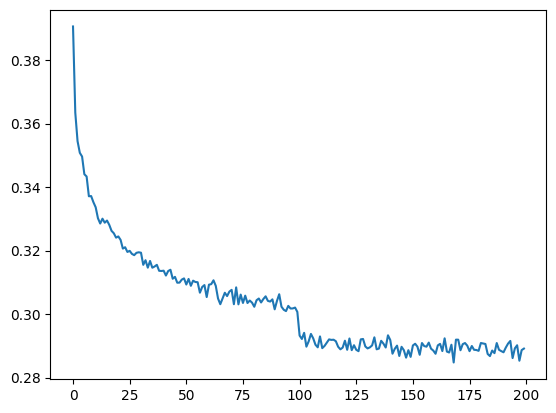

In [133]:
plt.plot(torch.tensor(lossi[:200000]).view(-1, 1000).mean(1))

In [134]:
# put layers into eval mode
for layer in model.layers:
  layer.training = False

In [135]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9244184494018555
val 2.0272305011749268


In [136]:
for _ in range(10):
  out = []
  context = [0] * block_size
  while True:
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out)) # decode and print the generated word

lansan.
dyar.
anani.
logista.
fynnleigh.
callis.
telan.
rivelin.
lynd.
zeyelte.
